<a href="https://colab.research.google.com/github/dpshepherd/PHY452_F2023/blob/main/Diffraction_fitting_PHY452_F2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install library to read tiff files

In [101]:
!pip install tifffile

### Import libraries to perform fitting

In [37]:
from tifffile import imread
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

### Define physical constants for the lab setup

In [272]:
lambda_light = 0.000561     # Wavelength of laser in mm
f1 = 250.0                  # Focal length of lens 1 in mm
f2 = 300.0                  # Focal length of lens 2 in mm
M = f2/f1                   # Magnification
pixel_spacing = 0.0069 / M  # Pixel spacing in mm accounting for magnification change

### Upload image of diffraction pattern and import as numpy array

In [38]:
uploaded = files.upload()
image_data = imread('/content/no_fourier_filter.ome.tif',is_ome=False)

### Plot image of diffraction pattern and middle line cut. The middle line cut is normalized by the peak intensity in the line cut.

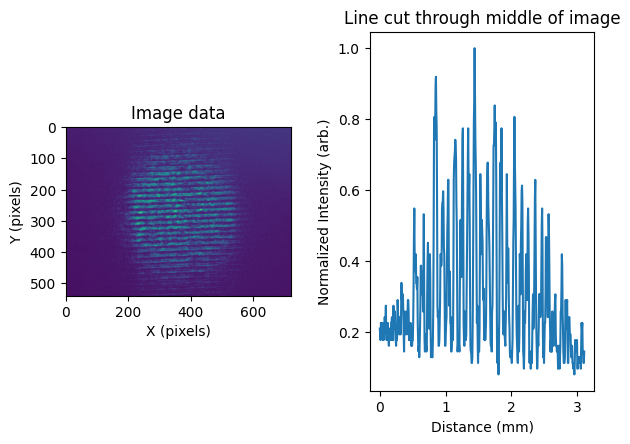

In [350]:
middle_line_cut = image_data[:,image_data.shape[1]//2]
middle_line_cut = middle_line_cut / np.max(middle_line_cut)
xdata = np.linspace(0,len(middle_line_cut),len(middle_line_cut))*pixel_spacing

fig, ax = plt.subplots(1,2)

ax[0].imshow(image_data)
ax[0].title.set_text('Image data')
ax[0].set_xlabel('X (pixels)')
ax[0].set_ylabel('Y (pixels)')

ax[1].plot(xdata,middle_line_cut)
ax[1].title.set_text('Line cut through middle of image')
ax[1].set_xlabel('Distance (mm)')
ax[1].set_ylabel('Normalized Intensity (arb.)')

fig.tight_layout(pad=2.0)

### Define fitting functions. This is where the physics you derived needs to be input.
Note that I added offset_x and offset_y to account for the data not being centered around x=0 and above the y axis. These help the fitting function.

In [340]:
def nslits_function(x, I0,d, N,offset_x,offset_y):

    # Calculate the spatial frequency for the diffraction orders
    u_n = np.arange(-N/2, N/2 + 1, 1) * (1 / (2 * d))

    # Calculate the sinc function for the slit width
    sinc_function = np.sinc((x-offset_x) / (lambda_light * f2) * d)

    # Calculate the diffraction pattern for each x value
    diffraction_pattern = np.zeros_like((x-offset_x), dtype=complex)
    for u in u_n:
        diffraction_pattern += np.exp(-1j * 2 * np.pi * u * (x-offset_x))

    # Calculate the electric field at the image plane
    E_i = sinc_function * diffraction_pattern

    # Calculate the irradiance
    I = I0*np.abs(E_i)**2 + offset_y

    return I

### Perform fit to data

In [357]:
# initial guesses
# you can change these to see the effect on the least squares fitting and final output
initial_I0 = 0.3
initial_d = 0.05
initial_N = 12
initial_offset_x = xdata[len(xdata)//2]
initial_offset_y = np.min(middle_line_cut)

# parameter bounds
parameter_guess = [initial_I0,initial_d,initial_N,initial_offset_x,initial_offset_y]

# perform curve fitting
result, _ = curve_fit(nslits_function,
                      xdata,
                      middle_line_cut,
                      p0=parameter_guess,
                      bounds=([0,.01,1,0,0],[1,.2,50,xdata[-1],0.2]))

# output results
print('I0 = '+str(np.round(result[0],4)))
print('slit width (d) = ' + str(np.round(result[1],4)) + ' mm')
print('slit spacing (2*d) = ' + str(np.round(2*result[1],4)) + ' mm')
print('Number of slits (N) = ' + str(np.round(result[2],2)))
print('X offset = ' + str(np.round(result[3],2)))
print('Y offset = ' + str(np.round(result[4],2)))

I0 = 0.0064
slit width (d) = 0.0509 mm
slit spacing (2*d) = 0.1018 mm
Number of slits (N) = 7.99
X offset = 1.54
Y offset = 0.2


### Plot result
Note: The intensity is not going to match perfectly due to the fact we did not use a pure plane wave. The important thing is to roughly get the solution correct for the N slit case.

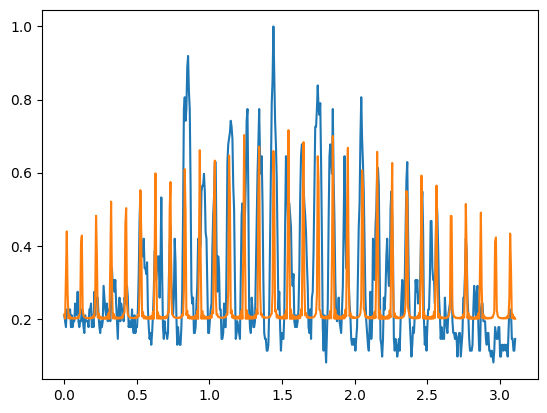

In [358]:
fitting_result = nslits_function(xdata,*result)

plt.plot(xdata,middle_line_cut)
plt.plot(xdata,fitting_result)